# 基于Mindspore构造非对称损失函数---Focal Loss损失函数

## 本小节主要介绍构造非对称损失函数的设计，使用MFocal Loss损失函数作为讲解实例。

非对称损失函数是指在二元分类问题中，将错误分类的影响不对称地考虑在损失函数中。

具体来说，当将正样本错误分类为负样本时，损失函数的值与将负样本错误分类为正样本时所得到的损失不同。

非对称损失函数可以提高模型对于特定类型错误分类的鲁棒性，常用于一些具有特定需求的应用场景，

例如医疗诊断中对于假阴性或假阳性的不同考虑，或者金融风控中对于错过欺诈案件和误判为欺诈的不同风险评估。

Focal Loss是常见的非对称损失函数，该损失函数通过引入一个可调节的指数因子来降低容易被正确分类的样本的权重，从而使模型更加关注那些难以分类的样本。
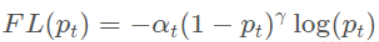

In [3]:
import mindspore.nn as nn
import mindspore.ops as ops

class FocalLoss(nn.loss.SoftmaxCrossEntropyWithLogits):
    """
    Focal Loss for multi-class classification
    """
    def __init__(self, gamma=2.0, alpha=0.25, **kwargs):
        super(FocalLoss, self).__init__(**kwargs)
        self.gamma = gamma
        self.alpha = alpha
        self.sigmoid = nn.Sigmoid()  # sigmoid激活函数用于将logits转换为概率值
        self.reduce_sum = ops.ReduceSum() # 用于计算各维度上元素之和

    def construct(self, logits, label):
        """
        :param logits: model's predictions, shape of [batch_size, num_classes]
        :param label: ground truth labels, shape of [batch_size, num_classes]
        :return: focal loss
        """
        logits = self.sigmoid(logits)  # 将logits转换为概率值
        ce_loss = super(FocalLoss, self).construct(logits, label) # 计算交叉熵损失

        pt = self.reduce_sum(logits * label, axis=1)   # 计算类别预测概率pt
        fp = ops.Pow()(1 - pt, self.gamma)            # 计算focusing parameter fp
  
        weight = label * self.alpha + (1 - label) * (1 - self.alpha)  # 计算balanced weight

        fl_loss = weight * fp * ce_loss    # 计算focal loss
        fl_loss = self.reduce_sum(fl_loss, axis=1)  # 按照样本维度求和

        return fl_loss.mean()    # 返回平均focal loss


这个案例中使用MindSpore中提供的SoftmaxCrossEntropyWithLogits损失函数来计算交叉熵损失。

需要先将logits转换为概率值，这里使用Sigmoid激活函数。

然后，计算类别预测概率pt和focusing parameter fp，以及平衡参数alpha和平衡权重weight。最后，计算focal loss并返回平均值。